## Ray-tune for Hyperparameter Turning

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/BoostcampAITech/lecture-note-python-basics-for-ai/blob/main/codes/pytorch/07_torch-study/ray-tune/ray_tune.ipynb)

In [2]:
from functools import partial
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

import wandb

ImportError: ray.tune in ray > 0.7.5 requires 'tabulate'. Please re-run 'pip install ray[tune]' or 'pip install ray[rllib]'.

#### model!

In [3]:
def load_data(data_dir="./data"):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform)

    testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform)

    return trainset, testset


In [4]:
class Net(nn.Module):
    def __init__(self, l1=120, l2=84):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

간단하게 마지막 두개의 층, l1, l2의 값만 하이퍼 파라미터로 받는다!

In [ ]:
def train_cifar(config, checkpoint_dir=None, data_dir=None):
    net = Net(config["l1"], config["l2"]) ## net 생성

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    trainset, testset = load_data(data_dir)

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    
    # wandb.init(project='torch-turn', entity='teamlab')
    wandb.watch(net) ## 입력받은 config 기반으로 wandb로 저장해준다
    ### 위에 있는 config 파일로 search space를 찾고, 그 중에 하나의 결과 값이 wandb에 들어가게 된다

    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        wandb.log({"val_loss": val_loss})
        wandb.log({"loss": loss})

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

학습하는 과정은 모두 동일하지만, 반드시 모델을 학습하는 총 과정을 하나의 함수로 만들어야 Ray를 사용할 수 있다!

In [ ]:
def test_accuracy(net, device="cpu"):
    trainset, testset = load_data()

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=4, shuffle=False, num_workers=2)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

#### main!

In [9]:
from ray.tune.suggest.bayesopt import BayesOptSearch
from ray.tune.suggest.hyperopt import HyperOptSearch

def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2):
    
    data_dir = os.path.abspath("./data")
    load_data(data_dir)
    config = {
        "l1": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "l2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "lr": tune.loguniform(1e-4, 1e-1),
        "batch_size": tune.choice([2, 4, 8, 16])
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    
    ## 실제적인 tune 
    result = tune.run(
        partial(train_cifar, data_dir=data_dir),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    ## get_best_trial : 가장 성능이 좋게 나온 결과값
    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

    best_trained_model = Net(best_trial.config["l1"], best_trial.config["l2"])
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.value
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)

    test_acc = test_accuracy(best_trained_model, device)
    print("Best trial test set accuracy: {}".format(test_acc))


if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    # wandb.login(key="0a25ae829bf4e2a6cd2acfdd4e65e6a26cd9927e")
    main(num_samples=10, max_num_epochs=10, gpus_per_trial=0) 

(pid=1074) [1,  2000] loss: 2.302
(pid=1072) [1,  2000] loss: 2.134
(pid=1074) [1,  4000] loss: 1.151
(pid=1072) [1,  4000] loss: 0.880
(pid=1074) [1,  6000] loss: 0.766
(pid=1074) [1,  8000] loss: 0.574
(pid=1072) [1,  6000] loss: 0.543
(pid=1074) [1, 10000] loss: 0.456
(pid=1072) [1,  8000] loss: 0.390
(pid=1074) [1, 12000] loss: 0.372
(pid=1072) [1, 10000] loss: 0.299
(pid=1074) [1, 14000] loss: 0.304
Result for DEFAULT_66247_00000:
  accuracy: 0.4759
  date: 2021-08-16_03-13-19
  done: false
  experiment_id: 7956bade02bf442aaf2057458cbd38d1
  hostname: 86cd04ebe720
  iterations_since_restore: 1
  loss: 1.434088040906191
  node_ip: 172.17.0.2
  pid: 1072
  should_checkpoint: true
  time_since_restore: 215.50442147254944
  time_this_iter_s: 215.50442147254944
  time_total_s: 215.50442147254944
  timestamp: 1629083599
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '66247_00000'
  
== Status ==
Memory usage on this node: 6.3/251.8 GiB
Using AsyncHyperBand: num_stopped

(pid=1074) 2021-08-16 03:13:19,829	ERROR worker.py:421 -- SystemExit was raised from the worker
(pid=1074) Traceback (most recent call last):
(pid=1074)   File "python/ray/_raylet.pyx", line 632, in ray._raylet.task_execution_handler
(pid=1074)   File "python/ray/_raylet.pyx", line 486, in ray._raylet.execute_task
(pid=1074)   File "python/ray/_raylet.pyx", line 523, in ray._raylet.execute_task
(pid=1074)   File "python/ray/_raylet.pyx", line 530, in ray._raylet.execute_task
(pid=1074)   File "python/ray/_raylet.pyx", line 534, in ray._raylet.execute_task
(pid=1074)   File "python/ray/_raylet.pyx", line 484, in ray._raylet.execute_task.function_executor
(pid=1074)   File "/home/work/.local/lib/python3.6/site-packages/ray/_private/function_manager.py", line 563, in actor_method_executor
(pid=1074)     return method(__ray_actor, *args, **kwargs)
(pid=1074)   File "/home/work/.local/lib/python3.6/site-packages/ray/tune/trainable.py", line 178, in train_buffered
(pid=1074)     result = sel

Best trial config: {'l1': 64, 'l2': 256, 'lr': 0.001437392863299655, 'batch_size': 4}
Best trial final validation loss: 1.434088040906191
Best trial final validation accuracy: 0.4759


TypeError: expected str, bytes or os.PathLike object, not NoneType

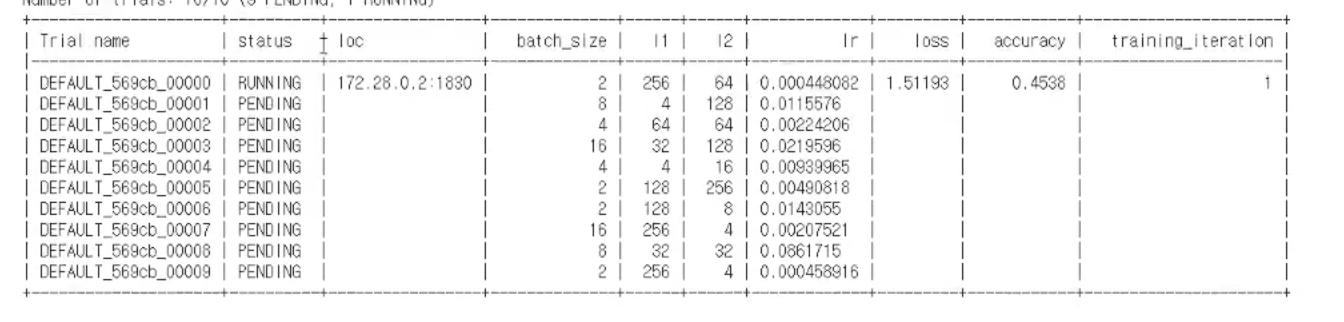

다음과 같이 성능을 보여준다